In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torch_geometric
from torch.utils.data import Subset, Dataset
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import networkx as nx
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import math
from einops import rearrange
from models_coarsen.gnet_coarsening import Sn_coarsen_layer, Sn_coarsen_net
from models_coarsen.gnet_coarsen_utils import get_clusters, get_cluster_idxs, \
                           get_masked_images, generate_grid_graph, \
                           prepare_data, run_exp
# reproducibility
np.random.seed(0)
torch.cuda.is_available()


/cis/home/nhuang19/anaconda3/envs/deepspeed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Set-up
- x: image
- y: rotated(image) + Gaussian_noise

In [5]:
#Load MNIST
MNIST_flag = False #True #False - FashionMNIST
subset_flag = True
N = 28

input_size  = N*N  # images are 28x28 pixels
output_size = 10      # there are 10 classes
noise_flag = True

if MNIST_flag:
    transformations = transforms.Compose([
                        transforms.Resize((N, N)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])  
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,transform=transformations)
    testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transformations)

else: #FashionMNIST
    transformations = transforms.Compose([
                        transforms.Resize((N, N)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
                    ])      
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True,transform=transformations)
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transformations)



##TO-DO: subset
if MNIST_flag:
    train_idx, validation_idx = train_test_split(np.arange(len(trainset)),
                                             train_size=100, #test_size=0.99,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=trainset.targets)
else:
    train_idx, validation_idx = train_test_split(np.arange(len(trainset)),
                                             train_size=100, #600,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=trainset.targets)
# Subset dataset for train and val
train_subset = Subset(trainset, train_idx)
validation_dataset = Subset(trainset, validation_idx) #NOT-USE


if subset_flag:
  train_loader = torch.utils.data.DataLoader(train_subset, batch_size=len(train_subset), shuffle=False)
else:
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False)

test_idx, test_rest_idx = train_test_split(np.arange(len(testset)),
                                             test_size=0.9,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=testset.targets)  
test_subset = Subset(testset, test_idx)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)
print(f"training_size={len(train_subset)}, test_size={len(test_subset)}")


training_size=100, test_size=1000


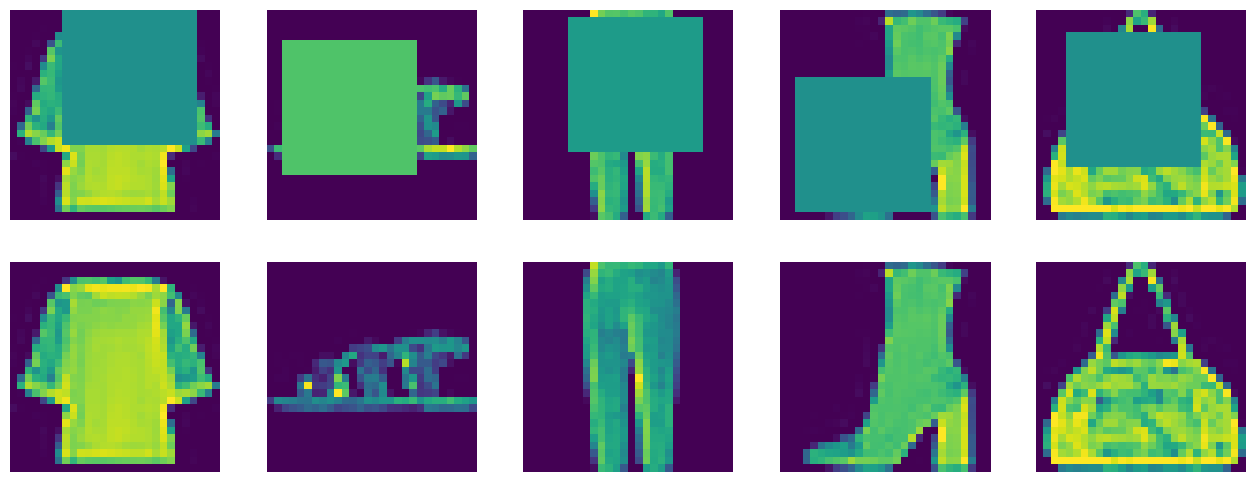

In [6]:
train_y, _ = next(iter(train_loader))
train_x = get_masked_images(train_y, mask_size=14 if MNIST_flag else 18)
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    #x, y = train_loader.dataset.__getitem__(i)
    #x, y = next(iter(train_loader))
    #x, label = train_loader.dataset.__getitem__(i)
    x = train_x[i] #gauss_noise_tensor(rotate_img(x))
    if MNIST_flag:
        plt.imshow(x.squeeze().numpy())
    else:
        plt.imshow(x.permute(1,2,0).numpy())
    plt.axis('off')

for j in range(5):
    plt.subplot(2, 5, j + 6)
    #y, label = train_loader.dataset.__getitem__(j)
    y = train_y[j]#add_gauss_noise(adjust_contrast(x))
    #y = add_gauss_noise(gamma_correct(x))
    if MNIST_flag:
        plt.imshow(y.squeeze().numpy())
    else:
        plt.imshow(y.permute(1,2,0).numpy())

    plt.axis('off')    

In [ ]:
#initialize new model instances
gpu_id = 1
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
in_features = 1
out_features = 1

total_runs = 3 #1
hid_dim = 28
n_epochs = 500
lr = 0.01 #for SGD seems 0.1 also works

if MNIST_flag:
    print(f"running MNIST")
    mask_size = 14 #"gamma" #"rotate" #"contrast"

else:
    print(f"running fashion!")
    mask_size = 20 #"gamma" #"rotate" #"contrast"

cluster_sizes = [1, 2, 4, 7, 14, 28]
#save

for run in range(total_runs):
#for run in range(total_runs-2, total_runs):
    results_val = dict()
    results_test = dict()

    print(f"running run={run}...")
    train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(train_loader, test_loader, device, mask_size)

    for size in cluster_sizes:
        print(f"Coarsen Sn: {size} x {size} clusters")
        torch.manual_seed(run)
        cluster_ids = get_cluster_idxs(N,size)
        model_coarsen_Sn = Sn_coarsen_net(cluster_ids, in_features, out_features, hid_dim=hid_dim)
        model_coarsen_Sn.to(device)
        #train_loss, test_loss
        best_val, best_test, model_coarsen_Sn = run_exp(model_coarsen_Sn, train_x, train_y, val_x, val_y, \
                                                            test_x, test_y, device, \
                                                            n_epochs=n_epochs, run=run, lr=lr, mask_size=mask_size)  
        name = f"Sn_coarsen{size}"
        results_val[name] = best_val.item()
        results_test[name] = best_test.item()

    if MNIST_flag:
        save_path = f"inpainting_results/val_test/mnist_{mask_size}_run={run}"
    else:
        save_path = f"inpainting_results/val_test/fashion_{mask_size}_run={run}"
    

    pickle.dump(results_test, open(f"{save_path}_test.pkl", "wb"))
    pickle.dump(results_val, open(f"{save_path}_val.pkl", "wb"))



In [11]:
def show_results(results_val, results_test):

    D_mean = {'name':[], 'val': [], 'test':[]}
    D_std = {'name':[], 'val': [], 'test':[]}
    for key in results_test[0].keys():
        D_mean['name'].append(key)
        D_std['name'].append(key)

        val_all = np.array([results_val[run][key] for run in range(total_runs)])
        mean = val_all.mean(axis=0) * 100
        D_mean['val'].append(mean)
        std = val_all.std(axis=0) * 100
        D_std['val'].append(std)

        val_all = np.array([results_test[run][key] for run in range(total_runs)])
        mean = val_all.mean(axis=0) * 100
        D_mean['test'].append(mean)
        std = val_all.std(axis=0) * 100
        D_std['test'].append(std)
        #print(f"Test MSE, {key}: mean={100*mean:.2f}, std={100*std:.2f}")

    df_mean = pd.DataFrame(data=D_mean).set_index("name").T
    df_std = pd.DataFrame(data=D_std).set_index("name").T

    return df_mean, df_std


In [12]:
total_runs = 3
MNIST_results_val = [pickle.load(open(f"inpainting_results/val_test/mnist_14_run={run}_val.pkl", "rb")) for run in range(total_runs)]
MNIST_results_test = [pickle.load(open(f"inpainting_results/val_test/mnist_14_run={run}_test.pkl", "rb")) for run in range(total_runs)]

fashion_results_val = [pickle.load(open(f"inpainting_results/val_test/fashion_20_run={run}_val.pkl", "rb")) for run in range(total_runs)]
fashion_results_test = [pickle.load(open(f"inpainting_results/val_test/fashion_20_run={run}_test.pkl", "rb")) for run in range(total_runs)]

MNIST_linear_val = [pickle.load(open(f"inpainting_results/linear/mnist_14_run={run}_val.pkl", "rb")) for run in range(total_runs)]
MNIST_linear_test = [pickle.load(open(f"inpainting_results/linear/mnist_14_run={run}_test.pkl", "rb")) for run in range(total_runs)]

fashion_linear_val = [pickle.load(open(f"inpainting_results/linear/fashion_20_run={run}_val.pkl", "rb")) for run in range(total_runs)]
fashion_linear_test = [pickle.load(open(f"inpainting_results/linear/fashion_20_run={run}_test.pkl", "rb")) for run in range(total_runs)]


In [13]:
df_mean, df_std = show_results(MNIST_results_val, MNIST_results_test)
fashion_df_mean, fashion_df_std = show_results(fashion_results_val, fashion_results_test)
linear_mean, linear_std = show_results(MNIST_linear_val, MNIST_linear_test)
fashion_linear_mean, fashion_linear_std = show_results(fashion_linear_val, fashion_linear_test)

In [14]:
df_merge = df_mean.apply(lambda col: "$" + col.round(2).astype(str)) + " \pm " + df_std.apply(lambda col: col.round(2).astype(str)) + "$ &"
df_merge

name,Sn_coarsen1,Sn_coarsen2,Sn_coarsen4,Sn_coarsen7,Sn_coarsen14,Sn_coarsen28
val,$38.97 \pm 1.97$ &,$37.92 \pm 2.1$ &,$35.19 \pm 1.58$ &,$34.24 \pm 2.2$ &,$34.23 \pm 1.74$ &,$34.51 \pm 2.01$ &
test,$41.56 \pm 0.16$ &,$40.53 \pm 0.26$ &,$36.06 \pm 0.24$ &,$34.68 \pm 0.5$ &,$33.67 \pm 0.07$ &,$33.92 \pm 0.04$ &


In [16]:
df_merge = fashion_df_mean.apply(lambda col: "$" + col.round(2).astype(str)) + " \pm " + fashion_df_std.apply(lambda col: col.round(2).astype(str)) + "$ &"
df_merge

name,Sn_coarsen1,Sn_coarsen2,Sn_coarsen4,Sn_coarsen7,Sn_coarsen14,Sn_coarsen28
val,$27.97 \pm 0.61$ &,$25.27 \pm 1.01$ &,$17.88 \pm 1.28$ &,$16.12 \pm 1.12$ &,$15.66 \pm 1.68$ &,$16.11 \pm 1.72$ &
test,$23.48 \pm 0.14$ &,$22.26 \pm 0.02$ &,$16.94 \pm 0.08$ &,$15.16 \pm 0.1$ &,$14.47 \pm 0.11$ &,$14.75 \pm 0.11$ &


/tmp/ipykernel_2798031/54245853.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


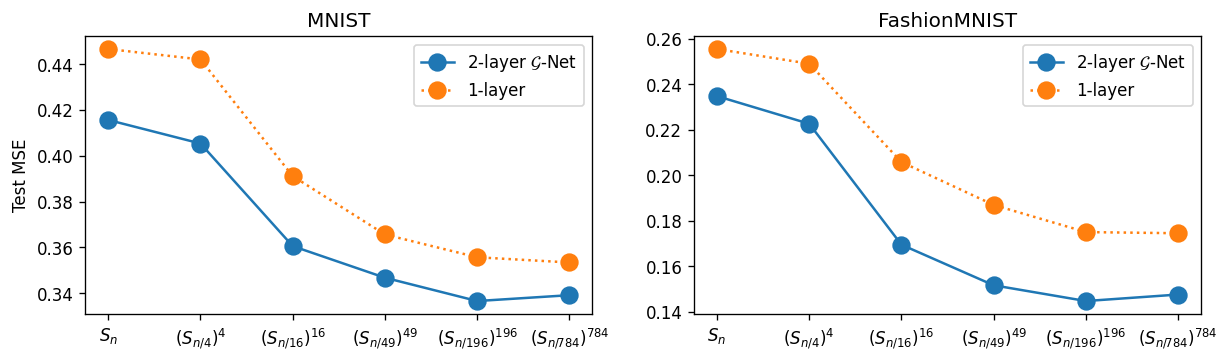

In [15]:
import matplotlib.ticker as mticker

plot_keys = [r"$S_n$",
            r"$(S_{{n/4}})^{4}$", 
            r"$(S_{{n/16}})^{16}$",
            r"$(S_{{n/49}})^{49}$",
            r"$(S_{{n/196}})^{196}$",
             r"$(S_{{n/784}})^{784}$"]
fig, axs = plt.subplots(ncols=2, figsize=(12,3), dpi=120)

axs[0].plot(df_mean.iloc[1]*0.01, marker="o", markersize="10", label=r"2-layer $\mathcal{G}$-Net")
# axs[0].fill_between(np.arange(6), df_mean.iloc[1]*0.01-df_std.iloc[1]*0.01, \
#                     df_mean.iloc[1]*0.01+ df_std.iloc[1]*0.01, alpha=0.3)

axs[0].plot(linear_mean.iloc[1]*0.01,marker="o", markersize="10", linestyle=":", label="1-layer")
axs[0].set_title("MNIST")

axs[1].plot(fashion_df_mean.iloc[1]*0.01, marker="o", markersize="10",label=r"2-layer $\mathcal{G}$-Net")
axs[1].plot(fashion_linear_mean.iloc[1]*0.01, marker="o", linestyle=":", markersize="10", label="1-layer")
axs[1].set_title("FashionMNIST")
for ax in axs:
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = plot_keys
    ax.set_xticklabels(labels)
    ax.legend()
axs[0].set_ylabel("Test MSE")
plt.show()